# basic set up

In [31]:
#basic set up
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [40]:

# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict

# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    '''
    Parameters
    ==========
    two_stage (boolean): whether to do two stage assignment or not
    
    Returns
    =======
    '''
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        return 0.1*dist

    # refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    if gurobiOptions is None:
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                            heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                # Select the targets
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    #clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes


def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## write pfsDesign file

In [35]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## set bench

In [34]:
# TODO: check with project office if the following function is correct
def create_bench():
    pfs_instdata_path = "./pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path

    cobra_coach_dir = "./cobra_coach_temp/"
    fiberids_path = "./pfs_utils-w.2024.45/data/fiberids/"
    pfs_black_dots_path = "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"

    spectrograph_modules = [1, 2, 3, 4]

    # create the grand fiber map
    def create_grand_fiber_map(fiberids_path):
        fibermap = FiberIds(path=fiberids_path)
        return fibermap

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")

    cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
    cobracoach.loadModel(version="ALL", moduleVersion=None)
    calibrationProduct = cobracoach.calibModel

    # Set some dummy center positions and phi angles for those cobras that have
    # zero centers
    zeroCenters = calibrationProduct.centers == 0
    calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
    calibrationProduct.phiIn[zeroCenters] = -np.pi
    calibrationProduct.phiOut[zeroCenters] = 0
    print("Cobras with zero centers: %i" % np.sum(zeroCenters))

    # Use the median value link lengths in those cobras with zero link lengths
    zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
    calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
    calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
    print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

    # Use the median value link lengths in those cobras with too long link lengths
    tooLongLinkLengths = (calibrationProduct.L1 > 100) | (calibrationProduct.L2 > 100)
    calibrationProduct.L1[tooLongLinkLengths] = np.median(calibrationProduct.L1[~tooLongLinkLengths])
    calibrationProduct.L2[tooLongLinkLengths] = np.median(calibrationProduct.L2[~tooLongLinkLengths])
    print("Cobras with too long link lengths: %i" % np.sum(tooLongLinkLengths))


    # Limit spectral modules
    gfm = create_grand_fiber_map(fiberids_path)
    cobra_ids_use = np.array([], dtype=np.uint16)
    for sm in spectrograph_modules:
        cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

    # Set Bad Cobra status for unused spectral modules
    for cobra_id in range(calibrationProduct.nCobras):
        if cobra_id not in cobra_ids_use:
            calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
    bench = Bench(
            layout="calibration",                       # Use the layout from the calibration product
            calibrationProduct=calibrationProduct,
            blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
            )

    return bench, cobracoach

## plot_filter_fov function

In [37]:

# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [38]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# main function

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv
In total, there are 1656943 targets.
Time passed - construct target list: 40.02 secs
There are 12 pointings.
  Your sample (gray), with the pointings (red):


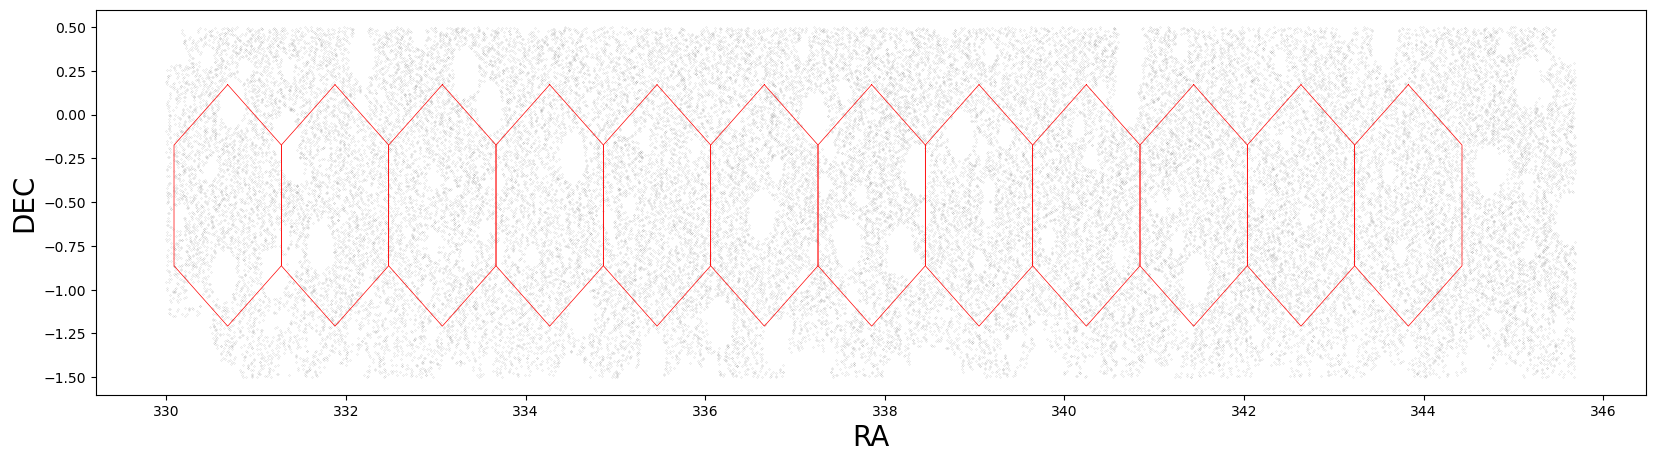

Time passed - read pointings and plot for a small region: 0.92 secs
Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-12 01:18:47.804Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-12 01:18:47.889Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-12 01:18:47.901Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-12 01:18:47.905Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250112_004


Cobras with zero centers: 0
Cobras with zero link lengths: 0
Cobras with too long link lengths: 0


2025-01-12 01:18:55.206Z root             10 CoordTransp.py:306 0.0
2025-01-12 01:18:55.211Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-12 01:18:55.213Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-12 01:18:55.215Z root             10 DistortionCoefficients.py:701 1e-08 mas
2025-01-12 01:18:55.348Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-12 01:18:55.354Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-12 01:18:55.355Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-12 01:18:55.357Z root             20 DistortionCoefficients.py:715 Ra Dec = (331.01190200999855 -0.3934771952557599) : applied presession
2025-01-12 01:18:55.435Z root             20 CoordTransp.py:312 FoV center: Ra,Dec=([330.682912] [-0.518103]) is Az,El,InR=(200.96093011908144 68.473097977061

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-12 01:18:56.000Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:18:56.004Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:18:56.007Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:18:56.011Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:18:56.012Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:06.436Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:06.438Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:19:06.440Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:06.442Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:06.445Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:19:06.449Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:19:06.454Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:19:06.460Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:19:06.462Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:19:06.466Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:19:06.468Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:19:06.469Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:19:06.470Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:19:06.473Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:19:06.490Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:19:07.231Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.72s


2025-01-12 01:19:07.232Z gurobipy         20 netflow.py:149 Presolve time: 0.72s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:19:07.240Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:19:07.253Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:19:07.260Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:19:07.268Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:19:07.270Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:19:07.272Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:19:07.280Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:19:07.287Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:19:07.289Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:19:07.292Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:19:07.301Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:19:07.308Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:19:07.311Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:19:07.313Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:19:07.317Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:19:07.331Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:19:07.333Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:19:07.335Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:07.337Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:07.340Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.89 seconds (0.35 work units)


2025-01-12 01:19:07.344Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.89 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:07.428Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:07.434Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.17s (can be avoided by choosing Method=3)


2025-01-12 01:19:07.458Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.17s (can be avoided by choosing Method=3)


2025-01-12 01:19:07.463Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:19:07.466Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:19:07.471Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.21 seconds (0.00 work units)


2025-01-12 01:19:07.479Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.21 seconds (0.00 work units)


2025-01-12 01:19:07.516Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:19:07.519Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:07.523Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:07.525Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:07.529Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:07.600Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.15 seconds (0.35 work units)


2025-01-12 01:19:07.603Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.15 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:19:07.607Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:19:07.609Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:07.612Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:07.615Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:19:07.618Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:19:07.625Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:19:08.186Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:19:08.187Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:08.401Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:08.430Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:08.432Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:19:08.433Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:19:08.435Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:19:08.436Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:19:08.462Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:19:08.487Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:19:16.771Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:19:16.773Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:19:16.776Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:19:16.779Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:19:16.781Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:25.540Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:25.541Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:19:25.544Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:25.545Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:25.548Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:19:25.552Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:19:25.553Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:19:25.562Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:19:25.564Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:19:25.569Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:19:25.573Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:19:25.578Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:19:25.580Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:19:25.581Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:19:25.599Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:19:26.343Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.72s


2025-01-12 01:19:26.345Z gurobipy         20 netflow.py:149 Presolve time: 0.72s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:19:26.352Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:19:26.390Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:19:26.497Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:19:26.508Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:19:26.523Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:19:26.526Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:19:26.539Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:19:26.541Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:19:26.545Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:19:26.548Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:19:26.551Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:19:26.554Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:19:26.556Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:19:26.559Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:19:26.562Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:19:26.566Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:19:26.568Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:19:26.570Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:26.573Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:26.576Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


2025-01-12 01:19:26.579Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:26.582Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:26.586Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-12 01:19:26.595Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-12 01:19:26.598Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:19:26.604Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:19:26.636Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.14 seconds (0.00 work units)


2025-01-12 01:19:26.642Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.14 seconds (0.00 work units)


2025-01-12 01:19:26.681Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:19:26.685Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:26.689Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:26.694Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:26.698Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:26.720Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


2025-01-12 01:19:26.722Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:19:26.723Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:19:26.726Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:26.728Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:26.730Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:19:26.732Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:19:26.736Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:19:27.308Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:19:27.309Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:27.429Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:27.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:27.473Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:19:27.474Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:19:27.475Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:19:27.477Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:19:27.506Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:19:27.532Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:19:35.661Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:19:35.662Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:19:35.665Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:19:35.667Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:19:35.669Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:46.615Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:19:46.617Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:19:46.619Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:46.621Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:19:46.623Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:19:46.687Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:19:46.741Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:19:46.750Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:19:46.755Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:19:46.761Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:19:46.804Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:19:46.807Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:19:46.811Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:19:46.814Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:19:46.835Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:19:47.590Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.72s


2025-01-12 01:19:47.592Z gurobipy         20 netflow.py:149 Presolve time: 0.72s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:19:47.599Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:19:47.641Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:19:47.650Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:19:47.670Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:19:47.673Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:19:47.676Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:19:47.680Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:19:47.682Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:19:47.685Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:19:47.689Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:19:47.690Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:19:47.693Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:19:47.696Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:19:47.698Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:19:47.700Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:19:47.703Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:19:47.706Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:19:47.709Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:47.712Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:19:47.715Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.09 seconds (0.35 work units)


2025-01-12 01:19:47.718Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.09 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:47.722Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:19:47.725Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-12 01:19:47.727Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-12 01:19:47.729Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:19:47.731Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:19:47.735Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-12 01:19:47.737Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-12 01:19:47.743Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:19:47.746Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:47.748Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:19:47.750Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:47.753Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:19:47.770Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.14 seconds (0.35 work units)


2025-01-12 01:19:47.900Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.14 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:19:47.902Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:19:47.906Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:47.909Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:19:47.912Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:19:47.914Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:19:47.919Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:19:48.664Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:19:48.671Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:48.841Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:48.881Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:19:48.884Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:19:48.885Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:19:48.886Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:19:48.888Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:19:48.917Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:19:48.944Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:19:56.897Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:19:56.899Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:19:56.903Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:19:56.905Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:19:56.907Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:07.672Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:07.674Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:20:07.677Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:07.679Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:07.681Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:20:07.684Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:20:07.686Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:20:07.695Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:20:07.698Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:20:07.702Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:20:07.706Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:20:07.708Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:20:07.710Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:20:07.712Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:20:07.731Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:20:08.581Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-12 01:20:08.583Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:20:08.590Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:20:08.598Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:20:08.611Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:20:08.617Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:20:08.619Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:20:08.620Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:20:08.628Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:20:08.641Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:20:08.648Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:20:08.651Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:20:08.653Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:20:08.655Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:20:08.662Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:20:08.664Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:20:08.666Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:20:08.669Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:20:08.672Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:20:08.758Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:08.761Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:08.765Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


2025-01-12 01:20:08.767Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:08.770Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:08.774Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-12 01:20:08.777Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-12 01:20:08.779Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:20:08.783Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:20:08.788Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.17 seconds (0.00 work units)


2025-01-12 01:20:08.790Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.17 seconds (0.00 work units)


2025-01-12 01:20:08.815Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:20:08.818Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:08.830Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:08.833Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:20:08.864Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:20:08.898Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.22 seconds (0.35 work units)


2025-01-12 01:20:08.901Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.22 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:20:08.904Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:20:08.906Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:08.908Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:08.912Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:20:08.915Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:20:08.921Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:20:09.544Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:20:09.545Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:09.660Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:09.694Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:09.698Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:20:09.699Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:20:09.700Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:20:09.700Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:20:09.729Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:20:09.755Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:20:17.999Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:20:18.001Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:20:18.004Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:20:18.006Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:20:18.009Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:28.929Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:28.930Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:20:28.933Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:28.934Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:28.937Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:20:28.941Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:20:28.943Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:20:28.948Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:20:28.950Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:20:28.954Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:20:28.958Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:20:28.960Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:20:28.962Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:20:28.965Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:20:28.993Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:20:29.722Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-12 01:20:29.723Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:20:29.731Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:20:29.737Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:20:29.740Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:20:29.751Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:20:29.754Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:20:29.756Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:20:29.760Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:20:29.763Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:20:29.766Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:20:29.768Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:20:29.771Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:20:29.773Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:20:29.775Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:20:29.777Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:20:29.780Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:20:29.783Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:20:29.787Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:20:29.789Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:29.791Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:29.793Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


2025-01-12 01:20:29.796Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:29.798Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:29.800Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-12 01:20:29.802Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-12 01:20:29.804Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:20:29.806Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:20:29.811Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:20:29.870Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:20:29.896Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:20:29.897Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:29.899Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:29.901Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:20:29.902Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:20:29.920Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-12 01:20:29.923Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:20:29.926Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:20:29.927Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:29.929Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:29.932Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:20:29.934Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:20:29.938Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:20:30.475Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:20:30.476Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:30.589Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:30.626Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:30.630Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:20:30.631Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:20:30.632Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:20:30.633Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:20:30.659Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:20:30.683Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:20:38.446Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:20:38.447Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:20:38.449Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:20:38.452Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:20:38.454Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:49.671Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:20:49.672Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:20:49.679Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:49.682Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:20:49.683Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:20:49.687Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:20:49.689Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:20:49.699Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:20:49.702Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:20:49.706Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:20:49.707Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:20:49.711Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:20:49.713Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:20:49.714Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:20:49.737Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:20:50.452Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-12 01:20:50.453Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:20:50.463Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:20:50.469Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:20:50.472Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:20:50.481Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:20:50.484Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:20:50.485Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:20:50.489Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:20:50.492Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:20:50.495Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:20:50.498Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:20:50.499Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:20:50.502Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:20:50.504Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:20:50.505Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:20:50.509Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:20:50.513Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:20:50.533Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:20:50.535Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:50.537Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:20:50.544Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


2025-01-12 01:20:50.546Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:50.548Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:20:50.558Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.07s


2025-01-12 01:20:50.567Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.07s


2025-01-12 01:20:50.569Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:20:50.573Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:20:50.579Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.10 seconds (0.00 work units)


2025-01-12 01:20:50.581Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.10 seconds (0.00 work units)


2025-01-12 01:20:50.588Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:20:50.589Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:50.591Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:20:50.593Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:20:50.604Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:20:50.632Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-12 01:20:50.636Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:20:50.640Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:20:50.643Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:50.659Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:20:50.662Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:20:50.668Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:20:50.676Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:20:51.366Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:20:51.367Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:51.482Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:51.518Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:20:51.521Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:20:51.523Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:20:51.524Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:20:51.524Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:20:51.549Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:20:51.577Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:20:59.417Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:20:59.419Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:20:59.421Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:20:59.424Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:20:59.426Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:08.346Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:08.347Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:21:08.351Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:08.353Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:08.355Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:21:08.360Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:21:08.361Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:21:08.367Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:21:08.370Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:21:08.374Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:21:08.376Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:21:08.378Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:21:08.379Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:21:08.381Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:21:08.513Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:21:09.281Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.74s


2025-01-12 01:21:09.283Z gurobipy         20 netflow.py:149 Presolve time: 0.74s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:21:09.290Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:21:09.295Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:21:09.300Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:21:09.304Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:21:09.306Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:21:09.311Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:21:09.315Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:21:09.319Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:21:09.321Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:21:09.324Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:21:09.326Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:21:09.327Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:21:09.329Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:21:09.331Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:21:09.333Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:21:09.337Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:21:09.339Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:21:09.342Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:09.357Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:09.360Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-12 01:21:09.364Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:09.367Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:09.369Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-12 01:21:09.370Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-12 01:21:09.372Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:21:09.376Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:21:09.382Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-12 01:21:09.386Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-12 01:21:09.392Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:21:09.394Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:09.397Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:09.399Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:21:09.401Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:21:09.430Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


2025-01-12 01:21:09.433Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:21:09.435Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:21:09.437Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:09.438Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:09.441Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:21:09.444Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:21:09.450Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:21:09.953Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:21:09.953Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:10.081Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:10.120Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:10.124Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:21:10.126Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:21:10.126Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:21:10.128Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:21:10.153Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:21:10.176Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:21:18.308Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:21:18.310Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:21:18.312Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:21:18.314Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:21:18.316Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:28.677Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:28.678Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:21:28.682Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:28.683Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:28.686Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:21:28.690Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:21:28.692Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:21:28.696Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:21:28.698Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:21:28.702Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:21:28.703Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:21:28.706Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:21:28.711Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:21:28.713Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:21:28.738Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:21:29.693Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.93s


2025-01-12 01:21:29.694Z gurobipy         20 netflow.py:149 Presolve time: 0.93s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:21:29.701Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:21:29.707Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:21:29.710Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:21:29.716Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:21:29.718Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:21:29.720Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:21:29.730Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:21:29.732Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:21:29.737Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:21:29.743Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:21:29.745Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:21:29.747Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:21:29.748Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:21:29.750Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:21:29.754Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:21:29.759Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:21:29.761Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:21:29.763Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:29.764Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:29.765Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


2025-01-12 01:21:29.768Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:29.770Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:29.772Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-12 01:21:29.775Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-12 01:21:29.778Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:21:29.781Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:21:29.785Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:21:29.786Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:21:29.798Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:21:29.800Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:29.802Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:29.808Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:21:29.813Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:21:29.841Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.15 seconds (0.35 work units)


2025-01-12 01:21:29.843Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.15 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:21:29.845Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:21:29.846Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:29.848Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:29.849Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:21:29.851Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:21:29.858Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:21:30.482Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:21:30.483Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:30.599Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:30.634Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:30.637Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:21:30.638Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:21:30.638Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:21:30.640Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:21:30.665Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:21:30.689Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:21:39.419Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:21:39.421Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:21:39.424Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:21:39.427Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:21:39.430Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:51.364Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:21:51.367Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:21:51.370Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:51.372Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:21:51.375Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:21:51.378Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:21:51.380Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:21:51.385Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:21:51.387Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:21:51.393Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:21:51.395Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:21:51.396Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:21:51.400Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:21:51.402Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:21:51.423Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:21:52.139Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-12 01:21:52.141Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:21:52.148Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:21:52.156Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:21:52.159Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:21:52.164Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:21:52.165Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:21:52.167Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:21:52.173Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:21:52.175Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:21:52.177Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:21:52.179Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:21:52.180Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:21:52.183Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:21:52.185Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:21:52.187Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:21:52.193Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:21:52.195Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:21:52.197Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:21:52.198Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:52.199Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:21:52.201Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-12 01:21:52.206Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:52.211Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:21:52.213Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-12 01:21:52.215Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-12 01:21:52.220Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:21:52.221Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:21:52.226Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:21:52.228Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-12 01:21:52.242Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:21:52.244Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:52.246Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:21:52.247Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:21:52.249Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-12 01:21:52.273Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


2025-01-12 01:21:52.275Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:21:52.277Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:21:52.282Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:52.297Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:21:52.299Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:21:52.306Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:21:52.311Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:21:52.967Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:21:52.968Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:53.131Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:53.166Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:21:53.169Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:21:53.170Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:21:53.171Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:21:53.173Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:21:53.198Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:21:53.226Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:22:01.644Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:22:01.647Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:22:01.651Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:22:01.654Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:22:01.666Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:13.441Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:13.442Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:22:13.445Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:13.447Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:13.450Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:22:13.453Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:22:13.455Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:22:13.461Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:22:13.462Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:22:13.467Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:22:13.469Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:22:13.477Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:22:13.479Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:22:13.480Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:22:13.511Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:22:14.332Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.78s


2025-01-12 01:22:14.334Z gurobipy         20 netflow.py:149 Presolve time: 0.78s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:22:14.341Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:22:14.347Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:22:14.351Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:22:14.359Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:22:14.361Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:22:14.363Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:22:14.370Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:22:14.372Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:22:14.374Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:22:14.376Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:22:14.385Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:22:14.387Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:22:14.411Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:22:14.579Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:22:14.581Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:22:14.586Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:22:14.589Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:22:14.596Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:14.599Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:14.603Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.15 seconds (0.35 work units)


2025-01-12 01:22:14.610Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.15 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:14.615Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:14.618Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.25s (can be avoided by choosing Method=3)


2025-01-12 01:22:14.624Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.25s (can be avoided by choosing Method=3)


2025-01-12 01:22:14.684Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:22:14.697Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:22:14.707Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.35 seconds (0.00 work units)


2025-01-12 01:22:14.710Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.35 seconds (0.00 work units)


2025-01-12 01:22:14.767Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:22:14.771Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:14.779Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:14.793Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:14.802Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:14.879Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.43 seconds (0.35 work units)


2025-01-12 01:22:14.881Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.43 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:22:14.883Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:22:14.885Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:14.886Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:14.888Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:22:14.890Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:22:14.894Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:22:15.662Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:22:15.664Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:15.852Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:15.901Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:15.905Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:22:15.909Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:22:15.911Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:22:15.912Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:22:15.944Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:22:15.970Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:22:25.355Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:22:25.357Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:22:25.359Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:22:25.360Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:22:25.362Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:38.047Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:38.048Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:22:38.051Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:38.054Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:38.057Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:22:38.061Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:22:38.062Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:22:38.067Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:22:38.069Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:22:38.075Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:22:38.081Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:22:38.083Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:22:38.086Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:22:38.089Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:22:38.115Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:22:38.950Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.81s


2025-01-12 01:22:38.952Z gurobipy         20 netflow.py:149 Presolve time: 0.81s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:22:38.959Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:22:38.965Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:22:38.969Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:22:38.975Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:22:38.976Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:22:38.980Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:22:38.986Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:22:38.988Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:22:38.990Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:22:38.992Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:22:38.994Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:22:38.995Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:22:38.998Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:22:39.009Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:22:39.011Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:22:39.014Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:22:39.016Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:22:39.024Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:39.026Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:39.029Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


2025-01-12 01:22:39.031Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:39.033Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:39.041Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.06s


2025-01-12 01:22:39.044Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.06s


2025-01-12 01:22:39.048Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:22:39.057Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:22:39.063Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-12 01:22:39.064Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-12 01:22:39.071Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:22:39.079Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:39.082Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:39.085Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:39.087Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:39.233Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


2025-01-12 01:22:39.236Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:22:39.240Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:22:39.244Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:39.248Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:39.250Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:22:39.253Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:22:39.258Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:22:39.790Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:22:39.791Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:39.913Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:39.951Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:22:39.956Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:22:39.958Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:22:39.959Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:22:39.960Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:22:39.994Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:22:40.029Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-12 01:22:48.549Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-12 01:22:48.551Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-12 01:22:48.553Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-12 01:22:48.556Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-12 01:22:48.559Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:58.533Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-12 01:22:58.536Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-12 01:22:58.539Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:58.543Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-12 01:22:58.545Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-12 01:22:58.547Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-12 01:22:58.550Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-12 01:22:58.555Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-12 01:22:58.563Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-12 01:22:58.575Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-12 01:22:58.577Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-12 01:22:58.578Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-12 01:22:58.579Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-12 01:22:58.581Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-12 01:22:58.668Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-12 01:22:59.473Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.77s


2025-01-12 01:22:59.476Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-12 01:22:59.484Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-12 01:22:59.491Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-12 01:22:59.496Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-12 01:22:59.512Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-12 01:22:59.513Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-12 01:22:59.516Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-12 01:22:59.532Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-12 01:22:59.535Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-12 01:22:59.549Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-12 01:22:59.553Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-12 01:22:59.558Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-12 01:22:59.563Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-12 01:22:59.579Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-12 01:22:59.650Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-12 01:22:59.654Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-12 01:22:59.664Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-12 01:22:59.672Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-12 01:22:59.676Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:59.680Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-12 01:22:59.683Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.14 seconds (0.35 work units)


2025-01-12 01:22:59.686Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.14 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:59.689Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-12 01:22:59.691Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.16s (can be avoided by choosing Method=3)


2025-01-12 01:22:59.694Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.16s (can be avoided by choosing Method=3)


2025-01-12 01:22:59.697Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-12 01:22:59.699Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-12 01:22:59.704Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.21 seconds (0.00 work units)


2025-01-12 01:22:59.706Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.21 seconds (0.00 work units)


2025-01-12 01:22:59.777Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-12 01:22:59.779Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:59.781Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-12 01:22:59.784Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:59.786Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-12 01:22:59.801Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.25 seconds (0.35 work units)


2025-01-12 01:22:59.803Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.25 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-12 01:22:59.806Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-12 01:22:59.808Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:59.809Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-12 01:22:59.811Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-12 01:22:59.813Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-12 01:22:59.818Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-12 01:23:00.718Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-12 01:23:00.719Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:23:00.847Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:23:00.884Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-12 01:23:00.888Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-12 01:23:00.889Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-12 01:23:00.890Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-12 01:23:00.892Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-12 01:23:00.924Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-12 01:23:00.957Z pfi              40 pfi.py:899 Some

KeyboardInterrupt: 

In [43]:
if __name__ == "__main__":
    # TODO: revise the two-stage code structure
    two_stage = True
    outdir = "../output/test/"
    
    t0 = time.time()
    ########################
    #cosmology + sky + star targets
    fn_list = ["cosmology_region3_3h_targets.ecsv", "star_region3_3h_targets.ecsv", "sky_region3_3h_targets.ecsv"]
    prefix_list = ["sci", "cal", "sky"]
    calibration_list = [False, True, True]
    
    tgt_s0, sample_sci = construct_tgt_list(catalog_path = "../data_proc/test/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
    '''
    # TODO: prepare ancillary science targets (smaller size sample)
    #anxillary science targets
    fn_list = ["anc_select.ecsv", ]
    prefix_list = ["anc", ]
    calibration_list = [False, ]
    
    tgt_s1, sample_sci_s1 = construct_tgt_list(catalog_path = "../data_proc/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    '''

    #total targets
    #tgt = tgt_s0 + tgt_s1
    tgt = tgt_s0
    
    n_sci = sample_sci.shape[0]
    ra_sci = sample_sci[:, 1].astype('float')
    dec_sci = sample_sci[:, 2].astype('float')

    t1 = time.time()
    print("Time passed - construct target list: %.2f secs" % (t1-t0))

    #set the range for getting pointing centers
    ra_min, ra_max, dec_min, dec_max = 330, 345, -1.5, 0.5

    # read the pointing centers from the file
    ra_peaks, dec_peaks = read_pointings("../output/cosmology_region3_pointings.txt")

    # select peaks within the range
    mask_peaks = (ra_peaks>ra_min) & (ra_peaks<ra_max) & (dec_peaks>dec_min) & (dec_peaks<dec_max)
    peaks = np.array([ra_peaks[mask_peaks], dec_peaks[mask_peaks]]).T
    npoint = peaks.shape[0]
    print("There are %d pointings." % npoint)
    
    # plot the pointing and samples
    plt.figure(figsize=(20, 5))
    print("  Your sample (gray), with the pointings (red):")
    fov_diag = 1.38/2. # deg, here it's radius
    mask_sci = (ra_sci>ra_min-fov_diag) & (ra_sci<ra_max+fov_diag) & (dec_sci>dec_min-fov_diag) & (dec_sci<dec_max+fov_diag)
    plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

    for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
        flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=0, n_sci_fov_least=4000, filter_fov=True)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig(outdir + 'cosmology_region3_test_fov_plot.png')
    plt.show()
    plt.close()
    
    t2 = time.time()
    print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))
    
    ########################
    # setup execute input parameters 
    ########################
    # bench = Bench(layout="full")
    
    # _create_configured_bench https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
    # bench, cobracoach = create_bench()
    
    
    # blackDotsMargin: The margin factor in radius of the black dots to avoid in fiber allocation.
    tele_params = {"otime":"2025-08-20T11:00:00Z", "posang":0.}
    gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)


    ########################
    classdict = def_classdict()

    ########################
    # one visit -- can be 1st or 2nd visit
    # TODO: set the alreadyObserved dictionary using the alreadyObserved column in the target list
    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0

    # set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets)
    for t in tgt:
        if t.targetclass[:3] == 'sci': t.stage = 1
    
    # use stage parameter instead of preassigned parameter
    outfn_list = []
    for peak in peaks[:1]:
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, collision_sim_version=2, two_stage=two_stage, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = 'cosmology_region3_3h_output_v1_ra%.2f_dec%.2f.txt'%(peak[0], peak[1])
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+'cosmology_region3_3h_v1_ra%.2f_dec%.2f.jpg'%(peak[0], peak[1]), Save=True, fn_fibeff=outdir+'cosmology_region3_3h_fibeff_v1.txt')
        
        # Convert scalar values to lists
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + 'cosmology_region3_3h_v1_ra%.2f_dec%.2f.csv'%(peak[0], peak[1]), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        for t in tgt_id_done:
            alreadyObserved[str(t)] = 1

    print("%f secs passed after the visits done." % (time.time()-t0))

    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1.jpg', figsize=(6, 5))
    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1_gray.jpg', figsize=(6, 5), plot_diffcolor=False)
    
    
    

In [42]:
#tclassdict = {'sci_P1' : 1, 'sky' : 2, 'cal' : 3}
#write_pfsDesign(outdir, 'pfsDesign_region3_3h_v1.txt', res, tpos, telescopes, tgt, classdict)

# TO-DO Lists
+ fix the problem of gurobi.lic in py_env_co_fa
+ update the target list after each observation
+ second visit, pointing center shift to avoid vignetting 
+ longer exposure option for second visit
+ (DONE!) remove the calibration targets in AlreadyObserved dict

+ (DONE!) CollisionSimulator versus SollisionSimulator2? 
+ cobra home position and collision simulator? 
+ generate 1h pfsDesign file using the code block above (CO will use first 6-8 hours)
+ (DONE!) (Q: iPS1 mag>18 is ok?) apply magnitude cut on bright stars
>>> Wanqiu: fainter than 16 (18 might be safer choice according to Andy)
+ (DONE) increase the sky/star fibers
>>> Masayuki - FLUXSTDs: 100-200 stars are good. Please distribute these stars uniformly across the field. 

+ fiberStatus? -- bad fibers and bad Cobra
+ apply bright star mask to sky/stars
+ generate uniform sky/star fiber assignment 
>>> Masato Onodera - I don't think I can put my script to check the uniformity of the distributions of sky and fluxstd objects against the home positions of science fibers. Please see the following gist how it's made. It uses dcor package for the comparsion, so making your own should be simple.
For the GA Fornax design, there is no configuration with p<0.05 (if my calculation is right).
https://gist.github.com/monodera/4c6fef2ce6a8370338250cd78ac78f26

>>> refer GA group code -
https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/nb/examples/netflow/8_cobra_groups.ipynb



# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)

